In [8]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds 

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Replace the base parameters
class_names = ['daisy', 'dandelion']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

c:\Users\kaynerodrigo\Documents\4th-year 1st Sem\RRL\Simulation\Yolov8n\rice\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [23]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, channels, height, width)
        # col_names=["input_size"] # uncomment for smaller output
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [13]:
train_dir = "ViT-sample/train"
test_dir = "ViT-sample/test"

In [17]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [24]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS,
):
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)
    
    # Get Class Names
    class_names = train_data.classes
    
    # turn images into data loadeers
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    
    return train_dataloader, test_dataloader, class_names
    

In [25]:
# setup data laoders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                            test_dir=test_dir,
                                                                                            transform=pretrained_vit_transforms,
                                                                                            batch_size=32)

In [26]:
import engine
# create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_classifier = engine.train(model=pretrained_vit,
                                         train_dataloader=train_dataloader_pretrained,
                                         test_dataloader=test_dataloader_pretrained,
                                         optimizer=optimizer,
                                         loss_fn=loss_fn,
                                         epochs=10,
                                         device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4308 | train_acc: 0.7957 | test_loss: 0.2677 | test_acc: 0.8556
Epoch: 2 | train_loss: 0.1986 | train_acc: 0.9159 | test_loss: 0.2079 | test_acc: 0.9020
Epoch: 3 | train_loss: 0.1531 | train_acc: 0.9423 | test_loss: 0.1857 | test_acc: 0.9124
Epoch: 4 | train_loss: 0.1282 | train_acc: 0.9519 | test_loss: 0.1627 | test_acc: 0.9408
Epoch: 5 | train_loss: 0.1146 | train_acc: 0.9591 | test_loss: 0.1565 | test_acc: 0.9460
Epoch: 6 | train_loss: 0.0957 | train_acc: 0.9688 | test_loss: 0.1427 | test_acc: 0.9512
Epoch: 7 | train_loss: 0.0797 | train_acc: 0.9760 | test_loss: 0.1360 | test_acc: 0.9512
Epoch: 8 | train_loss: 0.0704 | train_acc: 0.9808 | test_loss: 0.1357 | test_acc: 0.9512
Epoch: 9 | train_loss: 0.0628 | train_acc: 0.9808 | test_loss: 0.1316 | test_acc: 0.9512
Epoch: 10 | train_loss: 0.0563 | train_acc: 0.9856 | test_loss: 0.1292 | test_acc: 0.9588


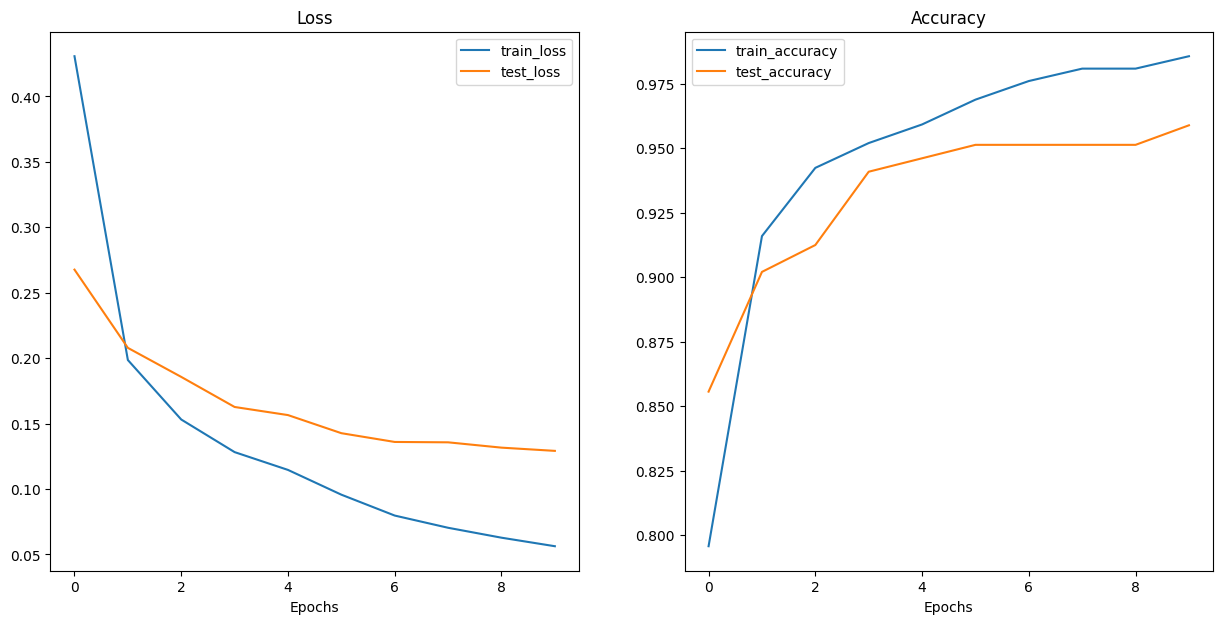

In [28]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_classifier) 

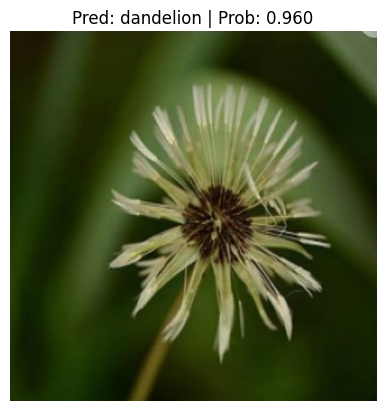

In [29]:
import requests

# Import function to make predictions on images and plot them 
from predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "test_img.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

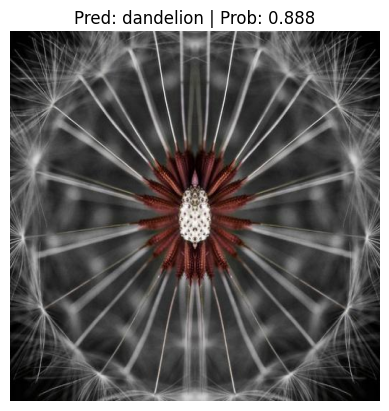

In [31]:
# Import function to make predictions on images and plot them 
from predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "test_1.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,class_names=class_names)